In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install transformers torch accelerate scikit-learn faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 54.4 MB/s eta 0:00:00:00:0100:01


In [2]:
# Prepare stock price history data
import json
import os

# Path to your folder containing .jsonl files
folder_path = r"/kaggle/input/finbert-data/stock_data/stock_data"

# Initialize an empty list to store the dictionaries from all files
stock_price_history_data_list = []

# Iterate over each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.jsonl'):
        file_path = os.path.join(folder_path, filename)

        # Open and read each file
        with open(file_path, 'r') as file:
            for line in file:
                # Convert each line into a dictionary and append to the list
                stock_price_history_data_list.append(json.loads(line))

stock_price_history_data = {}

In [3]:
stock_price_history_data_list[0]

{'stock': 'JAZZ',
 'month_year': '2018-12',
 'this_month_vw': 134.8922,
 'next_month_vw': 127.5001,
 'percentage_change': -0.054800055155153515}

In [4]:
for entry in stock_price_history_data_list:
    if entry['stock'] not in stock_price_history_data:
        stock_price_history_data[entry['stock']]={}
    stock_price_history_data[entry['stock']][entry['month_year']] = {
        'this_month_vw': entry['this_month_vw'],
        'next_month_vw': entry['next_month_vw'],
        'percentage_change': entry['percentage_change'],
    }
    

In [5]:
count=0
for i,j in stock_price_history_data.items():
    if count>=1:
        break
    print(i,j)
    count+=1
    

JAZZ {'2018-12': {'this_month_vw': 134.8922, 'next_month_vw': 127.5001, 'percentage_change': -0.054800055155153515}, '2019-02': {'this_month_vw': 128.7622, 'next_month_vw': 136.0457, 'percentage_change': 0.05656551379209118}, '2019-03': {'this_month_vw': 136.0457, 'next_month_vw': 135.2985, 'percentage_change': -0.005492272082101975}, '2019-04': {'this_month_vw': 135.2985, 'next_month_vw': 135.3316, 'percentage_change': 0.00024464424956683765}, '2019-05': {'this_month_vw': 135.3316, 'next_month_vw': 132.4349, 'percentage_change': -0.02140446133792854}, '2019-08': {'this_month_vw': 133.536, 'next_month_vw': 129.3078, 'percentage_change': -0.03166337167505403}, '2019-10': {'this_month_vw': 121.7081, 'next_month_vw': 137.2586, 'percentage_change': 0.12776881735891038}, '2019-12': {'this_month_vw': 149.6494, 'next_month_vw': 147.3195, 'percentage_change': -0.015569056741958263}, '2020-02': {'this_month_vw': 130.1444, 'next_month_vw': 108.477, 'percentage_change': -0.16648737863480864}, '20

In [6]:

file_path = r'/kaggle/input/finbert-data/Final_data'

# Initialize an empty list to store the dictionaries
training_data_list = []

# Open the file and read line by line
with open(file_path, 'r') as file:
    for line in file:
        # Convert each line into a dictionary and append to the list
        training_data_list.append(json.loads(line))

training_data = {}

for entry in training_data_list:
    if entry['stock'] not in training_data:
        training_data[entry['stock']] = {}
    training_data[entry['stock']][entry['month_year']] = entry['data']

In [7]:
training_data['TSLA']

{'2019-07': [{'title': "Today's Pickup: Shale Gas Production Might Have Dark Days Ahead",
   'date': '2019-07-31 16:32:00+00:00'},
  {'title': "'Elon Musk Tweeting on Tesla Production Raises Questions on SEC Deal' -Bloomberg; Note: Article References Solar Roofs Not Cars",
   'date': '2019-07-30 18:04:00+00:00'},
  {'title': 'Tesla Option Alert: Fri $250 Calls Sweep (3) near the Ask: 500 @ $0.82 vs 7656 OI; Ref=$239.92',
   'date': '2019-07-30 17:17:00+00:00'},
  {'title': "A Look At Benzinga Pro's Most-Searched Tickers For July 30, 2019",
   'date': '2019-07-30 17:13:00+00:00'},
  {'title': "Benzinga Pro's Top 10 Most-Searched Tickers For Morning of Tuesday., July 30, 2019",
   'date': '2019-07-30 15:33:00+00:00'},
  {'title': 'Tesla Option Alert: Fri $250 Calls at the Ask: 986 @ $0.761 vs 7656 OI; Ref=$238.135',
   'date': '2019-07-30 14:28:00+00:00'},
  {'title': "'Tesla Model 3 adds another 5-star safety rating to its collection' -Electrek",
   'date': '2019-07-30 12:45:00+00:00'},

In [8]:
import faiss
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
texts=[]
vectors=[]
targets=[]

In [10]:
vectorizer = TfidfVectorizer()
all_texts = []
for ticker in stock_price_history_data.keys():
    for month_year in stock_price_history_data[ticker].keys():
        if month_year in training_data[ticker]:
            headlines=[i['title'] for i in training_data[ticker][month_year]]
            all_texts.extend(headlines)
vectorizer.fit(all_texts)       

TfidfVectorizer()

In [11]:
for ticker in stock_price_history_data.keys():
    for month_year in stock_price_history_data[ticker].keys():
        if month_year in training_data[ticker]:
            headline=[i['title'] for i in training_data[ticker][month_year]]
            texts.append(headline)
            target=stock_price_history_data[ticker][month_year]['percentage_change']
            targets.append(target)
            vector=vectorizer.transform(headline).toarray()
            vectors.append(vector)

In [12]:
texts[0]

['Jazz Pharmaceuticals Receives New PDUFA Goal Date Of March 20 For Solriamfetol In Excessive Daytime Sleepiness Associated With Narcolepsy Or Obstructive Sleep Apnea',
 'The Daily Biotech Pulse: Tilray Inks Cannabis Drink Pact, Double Delight For Merck, FDA Snub For Spectrum',
 'The Week Ahead In Biotech: Conferences, PDUFA Dates And Clinical Trials',
 "Benzinga's Top Upgrades, Downgrades For December 12, 2018",
 'Oppenheimer Initiates Coverage On Jazz Pharmaceuticals with Outperform Rating, Announces $180 Price Target',
 'The Daily Biotech Pulse: Management Change At Merck, Jazz Buyback, Arrowhead Earnings',
 'Jazz Pharma Adds $400M To Buyback']

In [13]:
from sklearn.model_selection import train_test_split

# Randomly split the dataset into train and test sets for texts, targets, and vectors
train_texts, test_texts, train_targets, test_targets, train_vectors, test_vectors = train_test_split(
    texts, targets,vectors, test_size=0.1, random_state=42
)

In [14]:
test_texts[1004]

['Renewable Energy Group Option Alert: Jun 21 $17.5 Calls Sweep (21) above Ask!: 3010 @ $0.351 vs 317 OI; Ref=$15.89',
 '80 Biggest Movers From Friday',
 'Mid-Afternoon Market Update: Wesco Aircraft Jumps Following Upbeat Q2 Results; Renewable Energy Group Shares Slide',
 "58 Stocks Moving In Friday's Mid-Day Session",
 'Renewable Energy shares are trading lower after the company reported worse-than-expected Q1 EPS.',
 'Mid-Day Market Update: Dow Rises Over 200 Points; Harvard Bioscience Shares Plunge',
 'Mid-Morning Market Update: Markets Open Higher; DISH Network Earnings Miss Views',
 'Renewable Energy Group Q1 EPS $(1.11) Misses $(0.71) Estimate, Sales $478.2M Beat $477.34M Estimate']

In [15]:
# Query (vectorized)
k = 5
query_text = ["Latest stock prices news headlines"]
query_vector = vectorizer.transform(query_text).toarray().astype('float32')

In [16]:
from tqdm import tqdm

train_top_k_texts = []

# Wrap the iteration over texts with tqdm
for i, group_vectors in enumerate(tqdm(train_vectors)):
    dimension = group_vectors.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(group_vectors.astype('float32'))
    D, I = index.search(query_vector, k)

    selected_texts = [train_texts[i][selected_index] for selected_index in I[0]]

    train_top_k_texts.append(selected_texts) 

100%|██████████| 15173/15173 [00:23<00:00, 651.73it/s]


In [17]:
test_top_k_texts = []

# Wrap the iteration over texts with tqdm
for i, group_vectors in enumerate(tqdm(test_vectors)):
    dimension = group_vectors.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(group_vectors.astype('float32'))
    D, I = index.search(query_vector, k)

    selected_texts = [test_texts[i][selected_index] for selected_index in I[0]]

    test_top_k_texts.append(selected_texts) 

100%|██████████| 1686/1686 [00:02<00:00, 641.78it/s]


In [18]:
import torch
from torch import nn
from transformers import BertModel, BertTokenizer

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [20]:
class FinBERTRegressor(nn.Module):
    def __init__(self, finbert_model_name="ProsusAI/finbert", hidden_size=768, output_size=1):
        super(FinBERTRegressor, self).__init__()
        self.finbert = BertModel.from_pretrained(finbert_model_name)
        # Regression layer
        self.regressor = nn.Linear(hidden_size, output_size)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        with torch.no_grad():  # No need to calculate gradients for FinBERT
            outputs = self.finbert(input_ids=input_ids, attention_mask=attention_mask)

        # We use the [CLS] token's embedding for regression
        cls_embedding = outputs.last_hidden_state[:, 0, :]

        # Pass through the regression layer
        return self.regressor(cls_embedding)

In [21]:
model=FinBERTRegressor()
model.to(device)

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


FinBERTRegressor(
  (finbert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [22]:
tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [23]:
len(train_top_k_texts)

15173

In [24]:
train_top_k_texts[0]

['62 Biggest Movers From Friday',
 'Comfort Systems Analyst Upgrades HVAC Company After Sell-Off',
 "Benzinga's Top Upgrades, Downgrades For July 29, 2019",
 'DA Davidson Upgrades Comfort Systems USA to Buy',
 "45 Stocks Moving In Friday's Mid-Day Session"]

In [25]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from tqdm import tqdm  # Import tqdm

# Assuming 'texts' is your list of texts to be tokenized
train_input_ids = []
train_attention_masks = []


In [26]:
for group_text in tqdm(train_top_k_texts, desc="Tokenizing"):
    text = ". ".join(group_text) + "."
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens=True,
                        max_length=64,
                        pad_to_max_length=True,
                        return_attention_mask=True,
                        return_tensors='pt',
                   )

    train_input_ids.append(encoded_dict['input_ids'])
    train_attention_masks.append(encoded_dict['attention_mask'])

Tokenizing:   0%|          | 0/15173 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Tokenizing: 100%|██████████| 15173/15173 [00:5

In [27]:
len(train_input_ids)

15173

In [28]:
train_input_ids[0]

tensor([[  101,  5786,  5221,  2693,  2869,  2013,  5958,  1012,  7216,  3001,
         12941, 18739,  1044, 24887,  2194,  2044,  5271,  1011,  2125,  1012,
         17770, 28234,  1005,  1055,  2327, 18739,  1010,  2091, 24170,  2015,
          2005,  2251,  2756,  1010, 10476,  1012,  4830, 12017, 18739,  7216,
          3001,  3915,  2000,  4965,  1012,  3429, 15768,  3048,  1999,  5958,
          1005,  1055,  3054,  1011,  2154,  5219,  1012,   102,     0,     0,
             0,     0,     0,     0]])

In [29]:
train_input_ids[3].size()

torch.Size([1, 64])

In [30]:
len(train_targets)

15173

In [31]:
train_input_ids=torch.cat(train_input_ids,dim=0)
train_attention_masks=torch.cat(train_attention_masks,dim=0)

In [32]:
train_input_ids.size()

torch.Size([15173, 64])

In [33]:
train_targets=torch.tensor(train_targets)

In [34]:
train_targets.size()

torch.Size([15173])

In [35]:
#Create Tensor Dataset
dataset=TensorDataset(train_input_ids,train_attention_masks,train_targets)

In [36]:
#Dataloader
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [37]:
#loss function
loss_fn = nn.MSELoss()

In [38]:
#optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-5)

**Pre-Process the test split in the same way**

In [39]:
# Tokenize the test data
test_input_ids = []
test_attention_masks = []

for group_text in tqdm(test_top_k_texts, desc="Tokenizing Test Data"):
    text = ". ".join(group_text) + "."
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens=True,
                        max_length=64,
                        pad_to_max_length=True,
                        return_attention_mask=True,
                        return_tensors='pt',
                   )

    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])

test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_targets = torch.tensor(test_targets)

# Create TensorDataset for test data
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_targets)

# Create DataLoader for test data
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Tokenizing Test Data:   0%|          | 0/1686 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Tokenizing Test Data: 100%|██████████| 1686/1686 [00:05<00:00, 293.15it/s]


**Training Phase**

In [40]:
avg_train_loss_history = []
avg_test_loss_history = []
best_test_loss = float('inf')
best_epoch = 0
start_epoch=1
end_epoch=51

In [41]:
model_dir = 'model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [ ]:
for epoch in range(start_epoch, end_epoch):
    # Training Phase
    model.train()
    total_train_loss = 0

    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch}/{end_epoch - 1}')
    for batch in progress_bar:
        b_input_ids, b_input_mask, b_labels = [b.to(device) for b in batch]
        optimizer.zero_grad()
        outputs = model(b_input_ids, b_input_mask)
        loss = loss_fn(outputs.squeeze(), b_labels.float())
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.set_description(f"Epoch {epoch}/{end_epoch - 1} - Train Loss: {loss.item():.2f}")

    avg_train_loss = total_train_loss / len(dataloader)
    avg_train_loss_history.append(avg_train_loss)
    print(f'Epoch {epoch}/{end_epoch - 1} - Avg Train Loss: {avg_train_loss:.2f}')
    
    # Evaluation Phase
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch in test_dataloader:
            b_input_ids, b_input_mask, b_labels = [b.to(device) for b in batch]
            outputs = model(b_input_ids, b_input_mask)
            loss = loss_fn(outputs.squeeze(), b_labels.float())
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_loss_history.append(avg_test_loss)
    print(f'Epoch {epoch}/{end_epoch - 1} - Avg Test Loss: {avg_test_loss:.2f}')

    # Keep track of the best epoch
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        best_epoch = epoch

    # Save the model weights
    model_save_path = os.path.join(model_dir, f'model_epoch_{epoch}.pth')
    torch.save(model.regressor.state_dict(), model_save_path)
    print(f'Model saved for epoch {epoch} at {model_save_path}')

Epoch 1/50 - Train Loss: 0.10: 100%|██████████| 949/949 [00:32<00:00, 29.29it/s] 


Epoch 1/50 - Avg Train Loss: 0.25
Epoch 1/50 - Avg Test Loss: 0.13
Model saved for epoch 1 at model/model_epoch_1.pth


Epoch 2/50 - Train Loss: 0.07: 100%|██████████| 949/949 [00:31<00:00, 29.69it/s] 


Epoch 2/50 - Avg Train Loss: 0.24
Epoch 2/50 - Avg Test Loss: 0.12
Model saved for epoch 2 at model/model_epoch_2.pth


Epoch 3/50 - Train Loss: 0.03: 100%|██████████| 949/949 [00:31<00:00, 29.82it/s] 


Epoch 3/50 - Avg Train Loss: 0.23
Epoch 3/50 - Avg Test Loss: 0.12
Model saved for epoch 3 at model/model_epoch_3.pth


Epoch 4/50 - Train Loss: 0.03: 100%|██████████| 949/949 [00:31<00:00, 29.75it/s] 


Epoch 4/50 - Avg Train Loss: 0.23
Epoch 4/50 - Avg Test Loss: 0.12
Model saved for epoch 4 at model/model_epoch_4.pth


Epoch 5/50 - Train Loss: 0.37: 100%|██████████| 949/949 [00:31<00:00, 29.79it/s] 


Epoch 5/50 - Avg Train Loss: 0.23
Epoch 5/50 - Avg Test Loss: 0.12
Model saved for epoch 5 at model/model_epoch_5.pth


Epoch 6/50 - Train Loss: 0.04: 100%|██████████| 949/949 [00:31<00:00, 29.72it/s] 


Epoch 6/50 - Avg Train Loss: 0.23
Epoch 6/50 - Avg Test Loss: 0.12
Model saved for epoch 6 at model/model_epoch_6.pth


Epoch 7/50 - Train Loss: 0.04: 100%|██████████| 949/949 [00:31<00:00, 29.70it/s] 


Epoch 7/50 - Avg Train Loss: 0.23
Epoch 7/50 - Avg Test Loss: 0.12
Model saved for epoch 7 at model/model_epoch_7.pth


Epoch 8/50 - Train Loss: 0.02: 100%|██████████| 949/949 [00:31<00:00, 29.71it/s] 


Epoch 8/50 - Avg Train Loss: 0.23
Epoch 8/50 - Avg Test Loss: 0.12
Model saved for epoch 8 at model/model_epoch_8.pth


Epoch 9/50 - Train Loss: 0.06: 100%|██████████| 949/949 [00:31<00:00, 29.74it/s] 


Epoch 9/50 - Avg Train Loss: 0.23
Epoch 9/50 - Avg Test Loss: 0.12
Model saved for epoch 9 at model/model_epoch_9.pth


Epoch 10/50 - Train Loss: 0.04: 100%|██████████| 949/949 [00:31<00:00, 29.78it/s] 


Epoch 10/50 - Avg Train Loss: 0.23
Epoch 10/50 - Avg Test Loss: 0.12
Model saved for epoch 10 at model/model_epoch_10.pth


Epoch 11/50 - Train Loss: 0.01: 100%|██████████| 949/949 [00:31<00:00, 29.77it/s] 


Epoch 11/50 - Avg Train Loss: 0.22
Epoch 11/50 - Avg Test Loss: 0.12
Model saved for epoch 11 at model/model_epoch_11.pth


Epoch 12/50 - Train Loss: 0.13: 100%|██████████| 949/949 [00:31<00:00, 29.81it/s] 


Epoch 12/50 - Avg Train Loss: 0.22
Epoch 12/50 - Avg Test Loss: 0.12
Model saved for epoch 12 at model/model_epoch_12.pth


Epoch 13/50 - Train Loss: 0.03:  89%|████████▉ | 845/949 [00:28<00:03, 29.70it/s] 

In [45]:
print(f'Best epoch: {best_epoch} with Test Loss: {best_test_loss:.5f}')

Best epoch: 49 with Test Loss: 0.10980


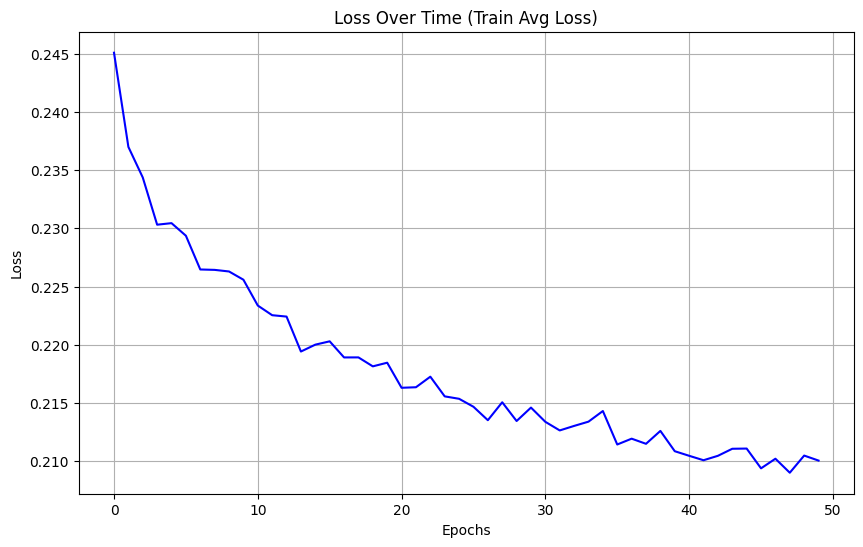

In [46]:
import matplotlib.pyplot as plt

# Creating the plot
plt.figure(figsize=(10, 6))  # Optional: You can adjust the figure size
plt.plot(avg_train_loss_history, linestyle='-', color='b')  # Line plot without markers

# Adding title and labels
plt.title('Loss Over Time (Train Avg Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Optionally, add a grid for easier reading
plt.grid(True)

# Show the plot
plt.show()

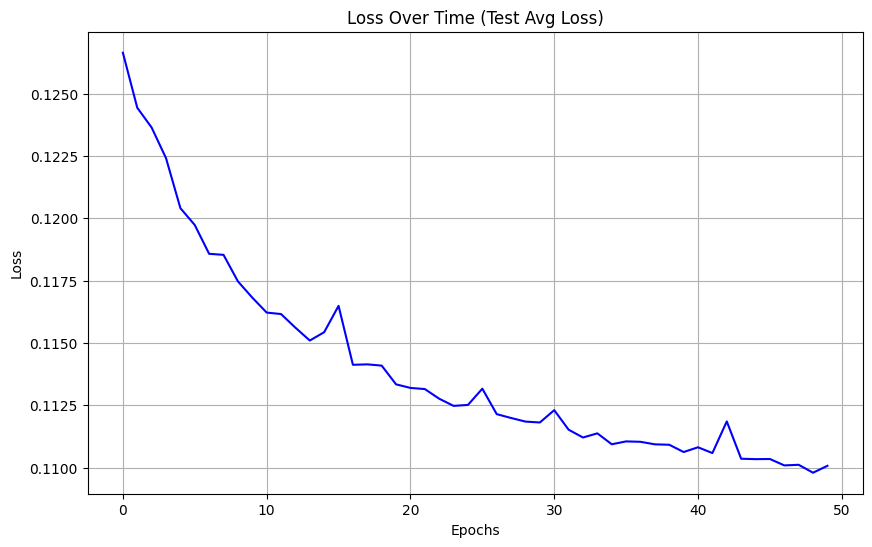

In [47]:
# Creating the plot
plt.figure(figsize=(10, 6))  # Optional: You can adjust the figure size
plt.plot(avg_test_loss_history, linestyle='-', color='b')  # Line plot without markers

# Adding title and labels
plt.title('Loss Over Time (Test Avg Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Optionally, add a grid for easier reading
plt.grid(True)

# Show the plot
plt.show()

## **Evaluating the model**

**MORGAN-STANLEY**

In [48]:
model.regressor.load_state_dict(torch.load('/kaggle/working/model/model_epoch_49.pth'))

<All keys matched successfully>

In [102]:
Stock_news = {}

# Iterate through the data
for month, news in training_data['MS'].items():
    # Initialize an empty list for each month
    Stock_news[month] = [item['title'] for item in news]
        

true_stocks={}
for month,stock in stock_price_history_data['MS'].items():
    true_stocks[month]=stock['percentage_change']

In [103]:
query_text = ["Latest stock prices news headlines"]
query_vector = vectorizer.transform(query_text).toarray().astype('float32')

In [104]:
top_stock_news={}

In [105]:
for month,news in Stock_news.items():
    headline_embeddings =vectorizer.transform(news).toarray()
    index = faiss.IndexFlatL2(headline_embeddings.shape[1])
    index.add(headline_embeddings)
    
    # Search for the top 5 most similar headlines
    distances, indices = index.search(query_vector, 5)
    
    # Retrieve the top 5 headlines
    top_stock_news[month] = [news[i] for i in indices[0]]

In [106]:
def predict_stock_price(data):
    predictions = {}

    for month, headlines in data.items():
        # Concatenate the headlines
        concatenated_headlines = " ".join(headlines)

        # Tokenize the concatenated headlines
        inputs = tokenizer(concatenated_headlines, return_tensors='pt', truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

    
        outputs = model(**inputs)
        predicted_stock_price = outputs.item()  

        predictions[month] = predicted_stock_price

    return predictions

In [107]:
predictions=predict_stock_price(top_stock_news)

In [108]:
import matplotlib.pyplot as plt


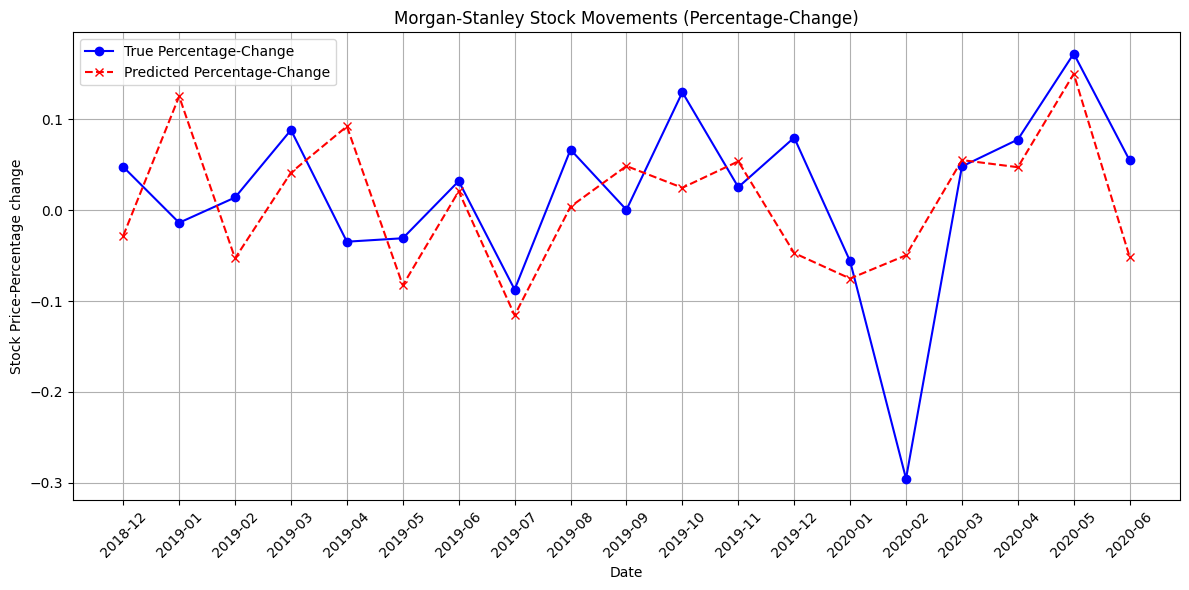

In [110]:
# Extract dates and values
dates = list(true_stocks.keys())
true_values = list(true_stocks.values())
predicted_values = list(predictions.values())

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(dates, true_values, color='blue', marker='o', label='True Percentage-Change')
plt.plot(dates, predicted_values, color='red', marker='x', linestyle='--', label='Predicted Percentage-Change')

# Adding titles and labels
plt.title('Morgan-Stanley Stock Movements (Percentage-Change)')
plt.xlabel('Date')
plt.ylabel('Stock Price-Percentage change')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Display plot
plt.tight_layout()
plt.show()

**CITI-GROUP Inc.**

In [166]:
Stock_news = {}

# Iterate through the data
for month, news in training_data['C'].items():
    # Initialize an empty list for each month
    Stock_news[month] = [item['title'] for item in news]
        

true_stocks={}
for month,stock in stock_price_history_data['C'].items():
    true_stocks[month]=stock['percentage_change']

In [167]:
query_text = ["Latest stock prices news headlines"]
query_vector = vectorizer.transform(query_text).toarray().astype('float32')

In [168]:
top_stock_news={}

In [169]:
for month,news in Stock_news.items():
    headline_embeddings =vectorizer.transform(news).toarray()
    index = faiss.IndexFlatL2(headline_embeddings.shape[1])
    index.add(headline_embeddings)
    
    # Search for the top 5 most similar headlines
    distances, indices = index.search(query_vector, 5)
    
    # Retrieve the top 5 headlines
    top_stock_news[month] = [news[i] for i in indices[0]]

In [170]:
predictions=predict_stock_price(top_stock_news)


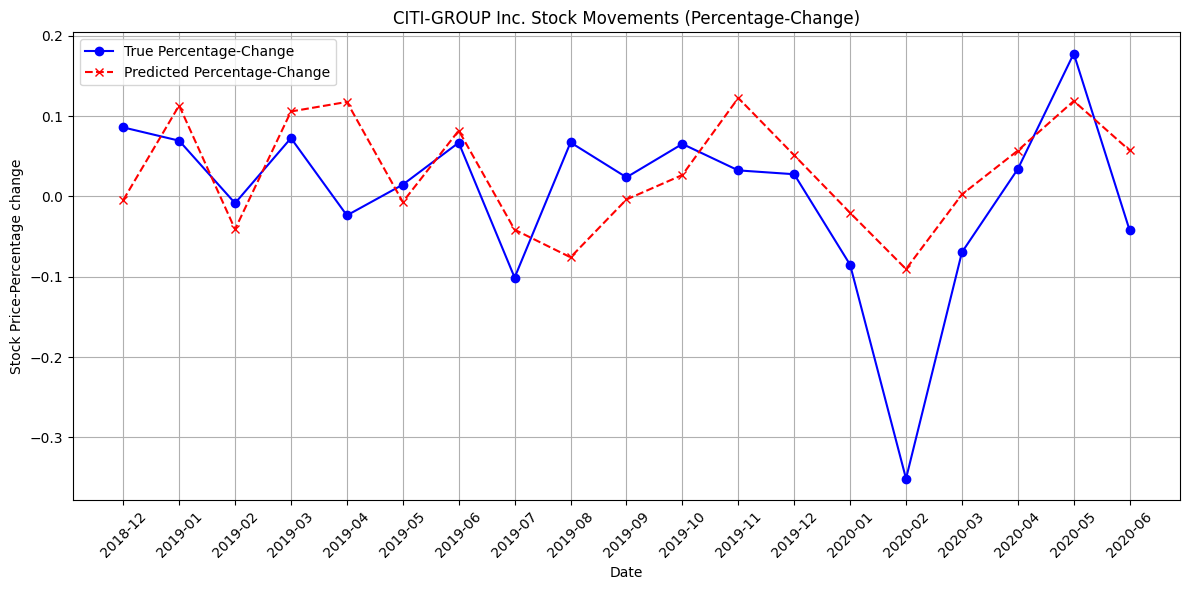

In [171]:
# Extract dates and values
dates = list(true_stocks.keys())
true_values = list(true_stocks.values())
predicted_values = list(predictions.values())

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(dates, true_values, color='blue', marker='o', label='True Percentage-Change')
plt.plot(dates, predicted_values, color='red', marker='x', linestyle='--', label='Predicted Percentage-Change')

# Adding titles and labels
plt.title('CITI-GROUP Inc. Stock Movements (Percentage-Change)')
plt.xlabel('Date')
plt.ylabel('Stock Price-Percentage change')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Display plot
plt.tight_layout()
plt.show()